In [1]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sb
import os
import re
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')


In [2]:
sb.set_style("whitegrid")
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["grid.linewidth"] = 2.0
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.1
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"]= 0.9
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = False
pd.options.display.max_columns = 1000

In [3]:
os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/MALARIA/"

In [4]:
# Esto no incluye toda las áreas del país. Sólo las áreas vistas en la base de datos de notifs.
notifs_das2depto = {
    "Escuintla": 5,
    "Alta Verapaz": 16,
    "Izabal" : 18,
    "Suchitepéquez" : 10,
    "Suchitepequez" : 10,
    "Santa Rosa" : 6,
    "Retalhuleu" : 11,
    "Petén Norte" : 17,
    "Peten Norte": 17,
    "Petén SurOccidente" : 17,
    "Petén SurOccidental" : 17,
    "Peten SurOriente" : 17,
    "Huehuetenango" : 13,
    "Quiché" : 14,
    "El Quiché": 14,
    "Petén Sur Oriental" : 17,
    "Baja Verapaz" : 15,
    "Sololá" : 7,
    "Zacapa" : 18,
    "Ixcán" : 14,
    "San Marcos" : 12,
    "Chimaltenango" : 4,
    "Guatemala Central" : 1,
    "Guatemala Sur" : 1,
    "Guatemala Nororiente" : 1,
    "Guatemala Noroccidente" : 1,
    "Ixil" : 14,
    "Jutiapa" : 22,
    "Chiquimula" : 20,
    "Ixcan" : 14,
    "El Progreso" : 2,
    "Guatemala Nororiental" : 1,
    "Quetzaltenango" : 9,
    "Jalapa": 21,
    "LNS": 1
}
code2depto = {
    5: "Escuintla",
    16:"Alta Verapaz",
    18: "Izabal",
    10: "Suchitepéquez",
    6: "Santa Rosa",
    11: "Retalhuleu",
    17: "Petén",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    7: "Sololá",
    18: "Zacapa",
    12: "San Marcos",
    4: "Chimaltenango",
    1: "Guatemala",
    22: "Jutiapa",
    20: "Chiquimula",
    2: "El Progreso",
    9: "Quetzaltenango",
    3: "Sacatepequez",
    21: "Jalapa"
}

In [5]:
bednets = pd.read_csv(base_dir + "GTM - Bednets Distr.csv", index_col = 0 , low_memory=False)
notifs = pd.read_excel(base_dir + "Base de datos 2016 - 2018 NAD.xlsx")

In [18]:
def clean(x):
    try: 
        return x.strip().lower()
    except:
        return np.NaN
notifs = notifs[notifs.AREA.notna()]
notifs["deptocode"] = notifs.AREA.map(str.strip).map(notifs_das2depto.get)
notifs["GENERO"] = notifs["GENERO"].apply(clean)
notifs["Gender"] = notifs.GENERO.map(lambda x: "Male" if x == "m" else "Female" if x == "f" else np.NaN)
notifs["Year"] = notifs["FECHA TOMA DE MUESTRA"].map(lambda y: y.year)

In [22]:
notifs.shape

(17405, 28)

In [20]:
notifsYear = notifs.groupby(["Año", "deptocode"]).AREA.count().unstack(0).fillna(0)
notifsYear, notifsYear.sum()

(Año        1900.0  2014.0  2015.0  2016.0  2017.0  2018.0
 deptocode                                                
 1             0.0     0.0     3.0    11.0    13.0     6.0
 2             0.0     0.0     2.0     0.0     2.0     0.0
 4             0.0     0.0    12.0     3.0     2.0     1.0
 5             5.0     1.0  3589.0  3194.0  2438.0  1555.0
 6             0.0     2.0    71.0   149.0    37.0    11.0
 7             0.0     0.0    16.0    10.0     1.0     2.0
 9             0.0     0.0     3.0     0.0     0.0     1.0
 10            1.0     0.0   152.0   241.0   300.0   223.0
 11            0.0     0.0   105.0    75.0    34.0    20.0
 12            0.0     0.0     8.0     3.0     8.0     0.0
 13            0.0     0.0    55.0    19.0    18.0     9.0
 14            0.0     0.0    62.0    32.0    22.0    25.0
 15            0.0     0.0    20.0     8.0    10.0     6.0
 16            0.0     0.0   798.0   544.0   751.0   787.0
 17            0.0     1.0   123.0   116.0   138.0   159

In [8]:
colvols5_2017 = pd.read_excel(base_dir + "Colaboradores Voluntarios  Escuintla 2017 y 2019.xlsx", 0, skiprows=3, usecols=[1,2,3,4])
colvols5_2019 = pd.read_excel(base_dir + "Colaboradores Voluntarios  Escuintla 2017 y 2019.xlsx", 1, skiprows=2, usecols=[1,2,3,4])


In [9]:
colvols5_2017 = colvols5_2017[colvols5_2017["Nombre del Colaborador Voluntario"].notna()]
colvols5_2019 = colvols5_2019[colvols5_2019["Nombre del Colaborador Voluntario"].notna()]

In [10]:
colvols5_2017.shape, colvols5_2019.shape

((186, 4), (186, 4))

In [13]:
mlp.rcParams['figure.figsize'] = [8, 8]

_i_ = lambda x: x

def mapGT(data_, chlor_col, scatter_col = None, labelChlor = None, labelScatter = None, ax_ = None, normalizeScatterSize = _i_,
          labels_adaptor = None):
    temp = data.deptosGTshp.merge(data_, 
                         left_on="deptocode", right_on = "deptocode", how="left" )
    if ax_ is None:
        ax = plt.axes()
    else:
        ax = ax_
    temp[temp[chlor_col].isna() | (temp[chlor_col]==0) | (np.isinf(temp[chlor_col]))].plot(color="#999999", ax= ax) 

    temp[(temp[chlor_col].isna()==False) & (temp[chlor_col]> -np.Inf)].plot(chlor_col, vmin = 0, vmax = temp[chlor_col].max()*1.3,
                                    legend=False, linewidth=0, cmap = "Blues", ax = ax)
    l1 = ax.get_legend()
    for i, depto in data.deptosGTshp.iterrows():
        plt.text(depto.geometry.centroid.x, depto.geometry.centroid.y-0.03, # (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5, 
                 hf.abbreviate(depto.DEPARTAMEN) + ("" if labels_adaptor is None else labels_adaptor(depto)), color="black",
                 horizontalalignment='center', alpha=0.8, fontsize=9)
    if scatter_col is not None:
        temp2 = data.deptosGTshp.merge(data_, 
                             left_on="deptocode", right_on = "deptocode", how="left" )\
            .assign(x = lambda row: row.geometry.centroid.x)\
            .assign(y = lambda row: row.geometry.centroid.y)
        temp2 = temp2[temp2[scatter_col]>0]
        plt.scatter(temp2.x, temp2.y, normalizeScatterSize(temp2[scatter_col]), c = "red", alpha=0.6, linewidths=1.5, edgecolors="black", 
                    label = labelScatter)
        plt.legend(bbox_to_anchor=(1,0))
    
    cmap = plt.get_cmap('Blues')
    vmax = temp[chlor_col].max()
    norm = mlp.colors.Normalize(vmin=0,vmax=vmax*1.3)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink = 0.75, boundaries = np.linspace(0,vmax,6)) #, ticks=np.linspace(0,vmax,10))
    #cbar.set_ticklabels([ for x in np.linspace(0,vmax,10)])
    cbar.set_label(labelChlor)
    
    data.munisGTshp[(data.munisGTshp.COD_MUNI__.isin([0, None]) == False) & 
                    (data.munisGTshp.COD_DEPT__.isin([0, None]) == False)].plot(edgecolor="#33333355", color="#00000000", linewidth=0.25, ax=ax)
    data.deptosGTshp.plot(edgecolor="#00000055", linewidth=1.5, color="#55555500", ax=ax)

    plt.axis("off")
    plt.tight_layout()


In [23]:
incidence = notifsYear.stack().rename("notifs").reset_index()
incidence["Population"] = incidence.apply(lambda x: 
                                      hf.GTDeptoPopulation(x.deptocode, x["Año"]), 1)

In [34]:
incidence["incidence"] = incidence.notifs/incidence.Population

/home/guillermo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
incidence

,deptocode,Año,notifs,Population,incidence
2,1,2015.0,3.0,3.436119e+06,8.730781e-07
3,1,2016.0,11.0,3.507203e+06,3.136403e-06
4,1,2017.0,13.0,3.579798e+06,3.631490e-06
5,1,2018.0,6.0,3.653937e+06,1.642065e-06
8,2,2015.0,2.0,1.686252e+05,1.186062e-05
9,2,2016.0,0.0,1.713648e+05,0.000000e+00
10,2,2017.0,2.0,1.741488e+05,1.148443e-05
11,2,2018.0,0.0,1.769781e+05,0.000000e+00
14,4,2015.0,12.0,6.622341e+05,1.812048e-05
15,4,2016.0,3.0,6.730965e+05,4.457013e-06


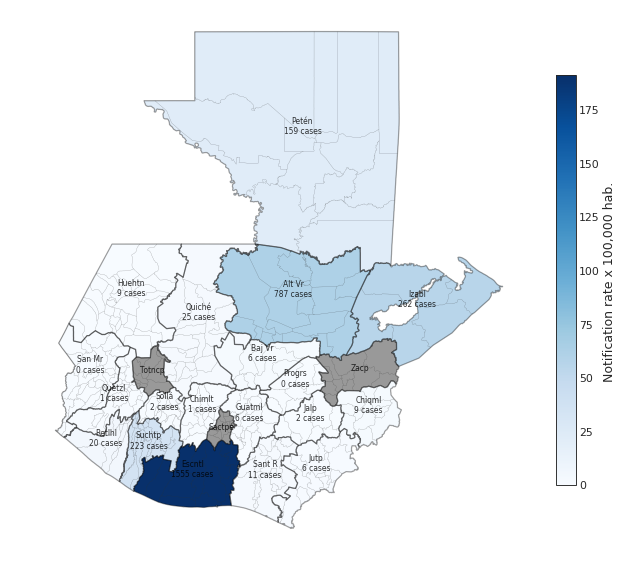

0

In [62]:
def a1(depto):
    datum = incidence[(incidence.deptocode == depto.deptocode) & (incidence["Año"] == 2018)]\
          .notifs.values
    if len(datum) > 0:
        return  "\n" + str(int(datum[0])) + " cases"
    return ""
mlp.rcParams["figure.figsize"] = (11,9.7)
mlp.rcParams["figure.dpi"] = 60
mapGT(incidence[incidence["Año"] == 2018].assign(
    Incidence = lambda x: x.incidence*1e5 ), "Incidence", labelChlor = "Notification rate x 100,000 hab. ", 
     labels_adaptor = a1) 
plt.show()
0

# ColVol

In [65]:
escuintlaDtoCode = {
    "Tiquisate": 506,
    "La Gomera": 507,
    "Santa Lucia Cotz.":  502,
    "Masagua":  505,
    "Democracia":  503
}

In [254]:
temp = colvols5_2017["Nombre del Distrito de Salud"].value_counts().rename("N").reset_index()

print(temp)

               index   N
0          Tiquisate  53
1          La Gomera  42
2  Santa Lucia Cotz.  40
3            Masagua  36
4         Democracia  15


In [255]:
temp["municode"] = temp["index"].map(escuintlaDtoCode).astype(str)
temp.municode.values[0]

'506'

In [256]:
n2018_esc = notifs[(notifs["Año"]==2018) & (notifs.deptocode==5)].groupby(["DISTRITO"]).apply(len)

In [257]:
n2018_esc = n2018_esc.rename({
    "Democracia": 503,
    "Escuintla":  501,
    "Gomera": 507,
    "Guanagazapa": 508,
    "Iztapa": 510,
    "Masagua": 505,
    "Nueva Concepción": 513,
    "Puerto San José": 509,
    "Santa Lucia Cotzumalguapa": 502,
    "Sipacate": 514,
    "Siquinala": 504,
    "Tiquisate": 506
})

n2018_esc = pd.DataFrame(n2018_esc)
n2018_esc.columns = ["cases"]
n2018_esc["pop"] = hf.GTMuniPopulation(n2018_esc.index, 2018).iloc[:,0]
n2018_esc["notrate"] = n2018_esc["cases"] / n2018_esc["pop"] * 100000


In [258]:
n2018_esc

,cases,pop,notrate
DISTRITO,,,
503,36,48837.348360,73.714076
501,15,169163.953488,8.867137
507,628,37921.505808,1656.052381
508,2,19214.331478,10.408897
510,7,13045.879434,53.656789
505,131,49642.850271,263.884929
513,51,70007.306294,72.849539
509,20,57460.369551,34.806598
502,337,142415.645770,236.631304


In [15]:
def abbreviate(i):
    """ Makes an abbreviation of a string
        
    """
    return i[0:3] + i[3:-1].replace("a", "").replace("e", "").replace("i", "").replace("o", "").replace("u", "")[0:4] \
                + i[-1]
hf.abbreviate = abbreviate

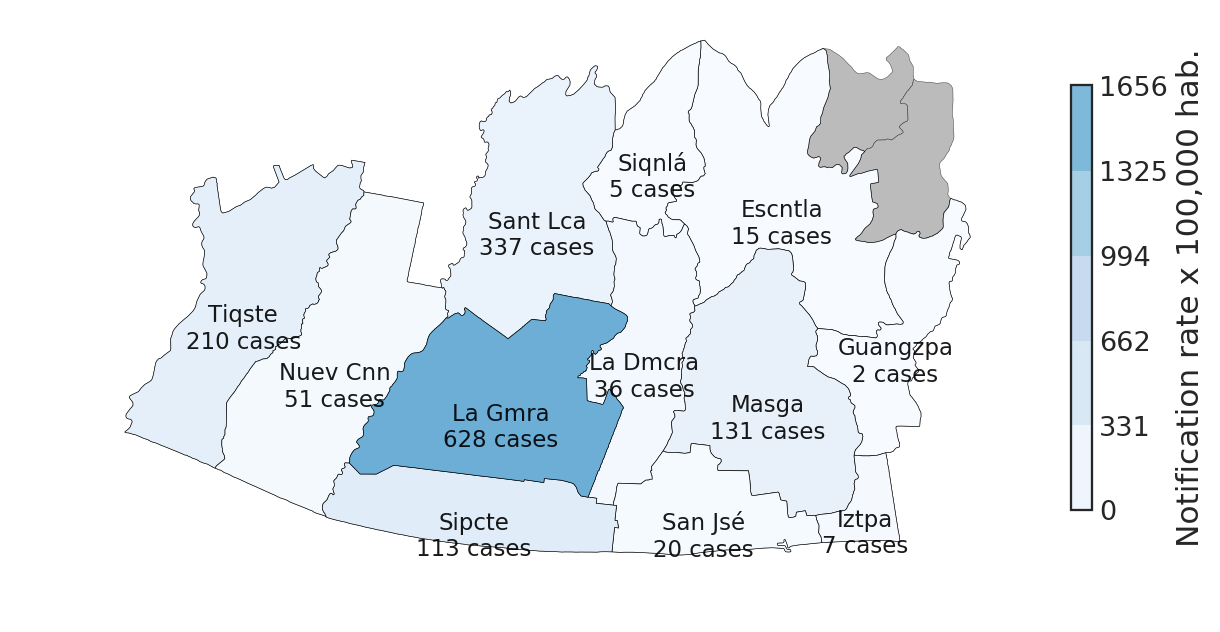

In [286]:
mlp.rcParams["figure.figsize"] = (10,5)
mlp.rcParams["figure.dpi"] = 150

ax = plt.axes()
data.munisGTshp\
    [(data.munisGTshp.COD_DEPT__ == "05")]\
.plot(edgecolor="#000000aa", color="#bbbbbb", linewidth=0.25, ax=ax)
mergeData = data.munisGTshp.merge(n2018_esc.assign(municode = lambda x: x.index.astype(str)), 
                                       left_on= "COD_MUNI__", right_on="municode", how="right")
vmax = mergeData["notrate"].max()
mergeData.plot("notrate", legend=False, linewidth=0.3, edgecolor="black", cmap = "Blues", ax = ax, vmax = vmax*2)
plt.axis("off")
#for i, muni in data.munisGTshp.merge(temp, 
#                         left_on = "COD_MUNI__", right_on = "municode", how = "right" )\
#            .iterrows():
#    plt.scatter(muni.geometry.centroid.x, muni.geometry.centroid.y, 
#                muni["N"]*20, c = "red", alpha=0.6, linewidths=1.5, edgecolors="black")
    
for i, muni in mergeData.iterrows():
    plt.text(muni.geometry.centroid.x, muni.geometry.centroid.y-0.05, # (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5, 
                 abbreviate(muni.NOMBRE__) + "\n" + str(muni.cases) + " cases", color="black",
                 horizontalalignment='center', alpha=0.9, fontsize=11)
#plt.scatter([], [], c='red', alpha=0.6, s=200, linewidths=1.5, edgecolors="black",
#        label = "Voluntary Collaborators")
#plt.legend(scatterpoints=1, bbox_to_anchor=(1,0))

cmap = plt.get_cmap('Blues')
norm = mlp.colors.Normalize(vmin=0,vmax=vmax*2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink = 0.75, boundaries = np.linspace(0,vmax,6)) #, ticks=np.linspace(0,vmax,10))
cbar.set_label("Notification rate x 100,000 hab.")

# https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html

# Impact Eval


In [5]:
model_3d_b = pd.DataFrame([
    {  "deptocode": 5, "cumbn_effect": -0.168  },
    {  "deptocode": 7, "cumbn_effect": -2.743  },
    {  "deptocode": 13, "cumbn_effect": -0.907  },
    {  "deptocode": 16, "cumbn_effect": -0.254  },
    {  "deptocode": 18, "cumbn_effect": -0.250  }
])
model_3d_b["effect"] =  np.exp(model_3d_b.cumbn_effect)
model_3d_b

,cumbn_effect,deptocode,effect
0,-0.168,5,0.845354
1,-2.743,7,0.064377
2,-0.907,13,0.403734
3,-0.254,16,0.775692
4,-0.250,18,0.778801


In [6]:
results = pd.read_csv(base_dir + "Gtm Malaria impact eval results 2018.csv")
modelData = model_3d_b.merge(results, right_on="deptocode", left_on = "deptocode", how = "right")
modelData

,cumbn_effect,deptocode,effect,Unnamed: 0,V1
0,-0.168,5,0.845354,9,3102.7
1,-2.743,7,0.064377,11,4.5
2,-0.907,13,0.403734,3,10.2
3,-0.254,16,0.775692,6,16099.5
4,-0.250,18,0.778801,8,307.6
5,NaN,10,NaN,1,27.5
6,NaN,11,NaN,2,9.1
7,NaN,14,NaN,4,1.5
8,NaN,15,NaN,5,3.3
9,NaN,17,NaN,7,23.1


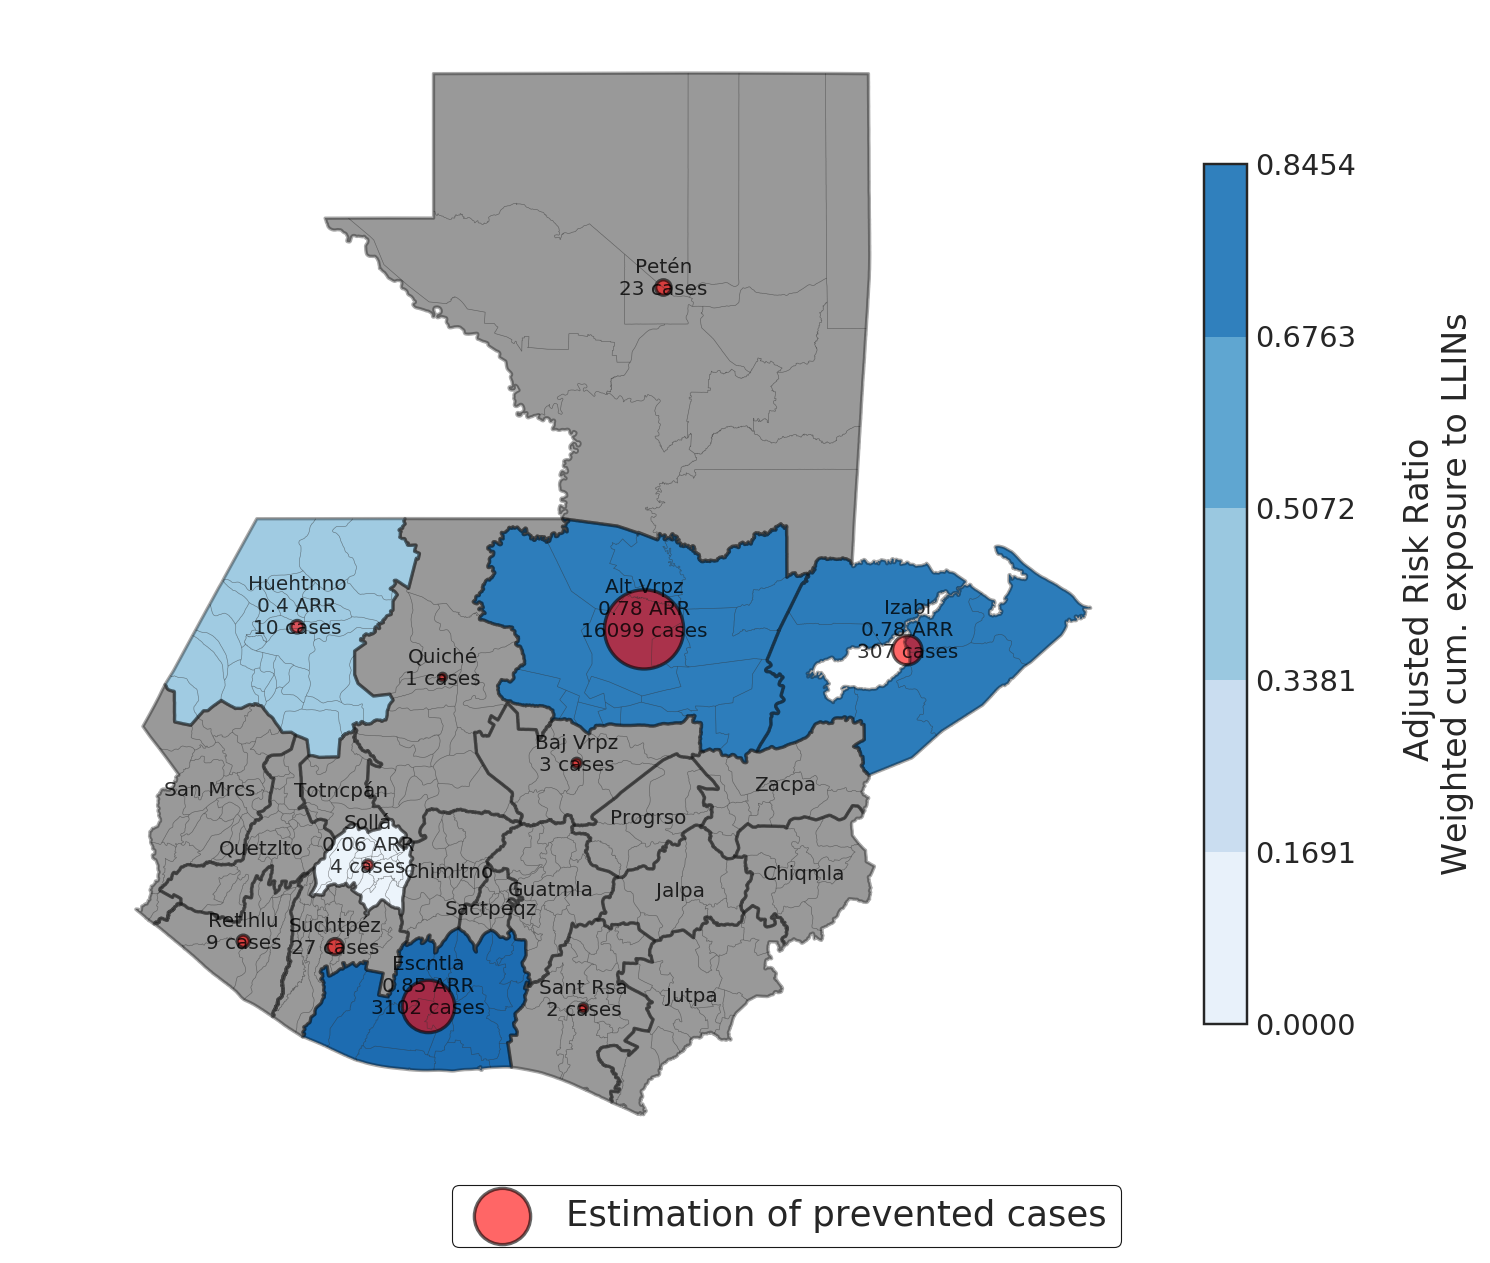

In [20]:
def a2(depto):
    datum = modelData[(modelData.deptocode == depto.deptocode)]
    if len(datum) > 0:
        return ( ("\n" + str(round(datum.effect.values[0], 2)) + " ARR") if datum.effect.notna().values[0] else "") +\
                    "\n" + str(int(datum.V1.values[0])) + " cases"
    return ""
mlp.rcParams["figure.figsize"] = (9.5,8)
mlp.rcParams["figure.dpi"] = 160
mapGT(modelData, "effect", "V1", labelChlor = "\nAdjusted Risk Ratio \nWeighted cum. exposure to LLINs",
      labelScatter= "Estimation of prevented cases",
     labels_adaptor = a2,
     normalizeScatterSize = lambda x: 10*np.sqrt(x)) 
plt.show()


In [223]:
results

,Unnamed: 0,deptocode,V1
0,1,10,27.5
1,2,11,9.1
2,3,13,10.2
3,4,14,1.5
4,5,15,3.3
5,6,16,16099.5
6,7,17,23.1
7,8,18,307.6
8,9,5,3102.7
9,10,6,2.5
